# Verify behavior cloning

Visually verify a behavior cloning based robot controller.

* Load the controller trained by the Train_BC notebook and the corresponding sp
* Choose a demonstration, to which the SP/BC pair will be applied to the images
* Visualize the path taken by the demonstration and what would be (autoregressively) recommended by the controller

In [ ]:
import sys
sys.path.append("..")

from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import pathlib
import pprint
import matplotlib.pyplot as plt

import torch
# import torch.nn as nn
# import torch.optim as optim
import numpy as np

from bc_factory import create_bc_model
# FIXME: factor this out
from bc_LSTM_MDN import bc_LSTM_MDN, mdn_loss

torch.manual_seed(1)
from sensorprocessing.sp_helper import get_transform_to_sp
from sensorprocessing.sp_factory import create_sp
from demonstration.demonstration import Demonstration

from robot.al5d_position_controller import RobotPosition

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

***ExpRun**: Loading pointer config file:
	C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml
Using device: cuda


In [2]:
experiment = "behavior_cloning"
# run = "bc_verify_mlp_00"
# run = "bc_verify_lstm_00"
# run = "bc_verify_lstm_resid_00"
run = "bc_verify_lstm_mdn_00"

exp = Config().get_experiment(experiment, run)
pprint.pprint(exp)

# Create the sp object described in the experiment
exp_sp = Config().get_experiment(exp["exp_sp"], exp["run_sp"])
sp = create_sp(exp_sp, device)
transform = get_transform_to_sp(exp_sp)

exp_robot = Config().get_experiment(exp["exp_robot"], exp["run_robot"])

# Load the bc model described in the experiment
exp_bc = Config().get_experiment(exp["exp_bc"], exp["run_bc"])
model, _, _ = create_bc_model(exp_bc, exp_sp, device)
model_path = pathlib.Path(exp_bc.data_dir(), exp_bc["controller_file"])
model.load_state_dict(torch.load(model_path))

***ExpRun**: Configuration for exp/run: behavior_cloning/bc_verify_lstm_mdn_00 successfully loaded
Experiment:
    batch_size: 64
    control_size: 6
    data_dir: c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\behavior_cloning\bc_verify_lstm_mdn_00
    epochs: 10
    exp_bc: behavior_cloning
    exp_robot: robot_al5d
    exp_run_sys_indep_file: C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\behavior_cloning\bc_verify_lstm_mdn_00.yaml
    exp_sp: sensorprocessing_conv_vae
    experiment_name: behavior_cloning
    loss: MSELoss
    optimizer: Adam
    optimizer_lr: 0.001
    run_bc: bc_lstm_mdn_00
    run_name: bc_verify_lstm_mdn_00
    run_robot: position_controller_00
    run_sp: sp_vae_256
    sequence_length: 10
    subrun_name: null
    test_data:
    - - random-both-cameras
      - '2025_03_08__14_23_19'
      - dev2
    - - random-both-cameras
      - '2025_03_08__14_24_52'
      - dev2
    training_data:
    - - random-both-camer

C:\Users\lboloni\AppData\Local\Temp\ipykernel_115112\953613827.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [3]:
pred_path = pathlib.Path(exp.data_dir(), "pred.npy")
real_path = pathlib.Path(exp.data_dir(), "real.npy")

if pred_path.exists():
    a_pred_np = np.load(pred_path)
    a_real_np = np.load(real_path)
    print(f"Paths successfully loaded from\n{pred_path.relative_to(pathlib.Path.home())}")
else:
    a_real_list = []
    a_pred_list = []
    with torch.no_grad(): # disable gradient computation
        for val in exp["verification_data"]: # for all demonstrations
            run, demo_name, camera = val
            exp_demo = Config().get_experiment("demonstration", run)
            demo = Demonstration(exp_demo, demo_name)
            for i in range(demo.metadata["maxsteps"]-exp_bc["sequence_length"]): # -1 because of lookahead
                if exp_bc["sequence_length"]:
                    input_list = []
                    # FIXME make it sliding window
                    for j in range(exp_bc["sequence_length"]):
                        sensor_readings, _ = demo.get_image(i+j, device=device, transform=transform, camera=camera)
                        z = sp.process(sensor_readings)
                        input_list.append(z)
                        input_nd = np.array(input_list)
                        z_tensor = torch.tensor(input_nd).unsqueeze(0).to(device)
                else:
                    sensor_readings, _ = demo.get_image(i, device=device, transform=transform, camera=camera)
                    z = sp.process(sensor_readings)
                    z_tensor = torch.tensor(z).unsqueeze(0).to(device)
                if not isinstance(model, bc_LSTM_MDN):                
                    a_pred = model(z_tensor)
                else:
                    a_pred = model.forward_and_sample(z_tensor)
                a_pred_list.append(a_pred.to("cpu").squeeze(0))
                a = demo.get_action(i)
                rp = RobotPosition.from_vector(exp_robot, a)
                a_real = rp.to_normalized_vector(exp_robot)            
                a_real_list.append(a_real)
    a_pred_np = np.array(a_pred_list)
    a_real_np = np.array(a_real_list)

    # save the comparison terms
    np.save(pred_path, a_pred_np)
    np.save(real_path, a_real_np)            

Paths successfully loaded from
Documents\Code\_TempData\BerryPicker-experiments\behavior_cloning\bc_verify_lstm_mdn_00\pred.npy


## Plot the differences between the a_real and a_pred

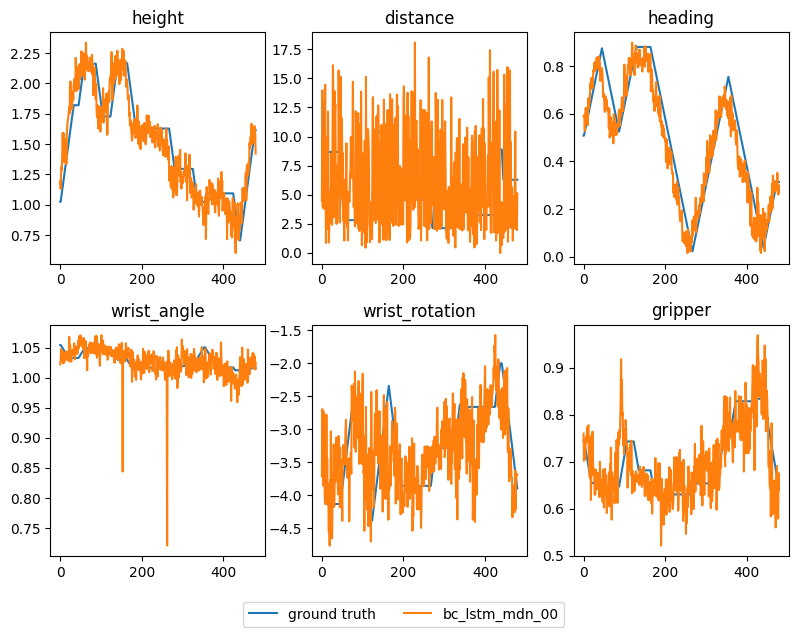

In [4]:


fig, axs = plt.subplots(2,3, figsize=(8, 6))
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(exp_bc["control_size"]):
    ax = axs[i//3, i%3]
    #ax.set_ylim(0, 1.4)
    ax.plot(a_real_np[:,i], label="ground truth")
    ax.plot(a_pred_np[:,i], label=exp_bc["name"])
    if i==0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, ncol=2,
            bbox_to_anchor=(0.5, 0), loc="upper center")
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(exp.data_dir(), "bccomparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')

In [5]:
a_real_np.shape
a_real_np[:,1]

array([13.142858 , 13.142858 , 12.428572 , 11.714286 , 11.       ,
       10.285714 ,  9.571428 ,  8.857142 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,  8.669051 ,
        8.669051 ,  7.954766 ,  7.24048  ,  6.526194 ,  5.8119087,
        5.097623 ,  4.383337 ,  3.6690514,  2.9547656,  2.799464 ,
        2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,
        2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,
        2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,
        2.799464 ,  2.799464 ,  2.799464 ,  2.799464 ,  2.7994

In [6]:
a_pred_np.shape

(480, 6)

In [7]:
exp_bc

Experiment:
    batch_size: 64
    control_size: 6
    controller: bc_LSTM_MDN
    controller_file: controller.pth
    data_dir: c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\behavior_cloning\bc_lstm_mdn_00
    epochs: 40
    exp_mdn: behavior_cloning
    exp_robot: robot_al5d
    exp_run_sys_indep_file: C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\behavior_cloning\bc_lstm_mdn_00.yaml
    exp_sp: sensorprocessing_conv_vae
    experiment_name: behavior_cloning
    hidden_size: 32
    loss: MSELoss
    name: bc_lstm_mdn_00
    optimizer: Adam
    optimizer_lr: 0.001
    run_mdn: mdn_for_bc_00
    run_name: bc_lstm_mdn_00
    run_robot: position_controller_00
    run_sp: sp_vae_256
    sequence_lenght: 10
    sequence_length: 10
    subrun_name: null
    test_data:
    - - random-both-cameras
      - '2025_03_08__14_23_19'
      - dev2
    - - random-both-cameras
      - '2025_03_08__14_24_52'
      - dev2
    training_data:
    - - ran